In [3]:
import exoplanet as xo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


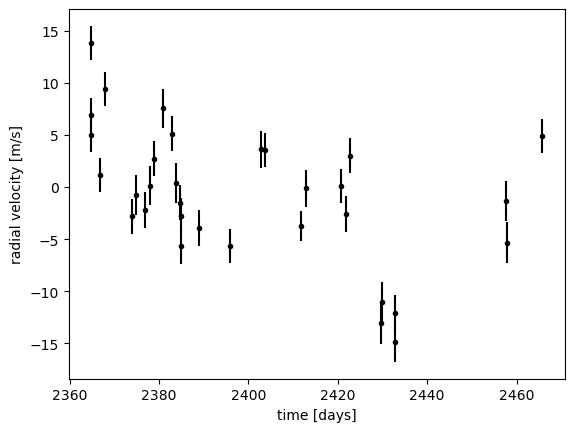

In [4]:
url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 1000)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
_ = plt.ylabel("radial velocity [m/s]")

In [5]:
periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


In [6]:
0.5 * (
    np.log(np.array(periods) + np.array(period_errs))
    - np.log(np.array(periods) - np.array(period_errs))
)

array([1.43643076e-05, 1.41632026e-05])

In [7]:
with pm.Model() as model:

    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    logP = pm.Normal(
        "logP",
        mu=np.log(periods),
        sd=np.array(period_errs) / np.array(periods),
        shape=2,
        testval=np.log(periods),
    )
    P = pm.Deterministic("P", tt.exp(logP))

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal(
        "logK", mu=np.log(Ks), sd=2.0, shape=2, testval=np.log(Ks)
    )

    # Eccentricity & argument of periasteron
    ecs = pmx.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
    ecc = pm.Deterministic("ecc", tt.sum(ecs**2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    xo.eccentricity.vaneylen19(
        "ecc_prior", multi=True, shape=2, fixed=True, observed=ecc
    )
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)

    # Then we define the orbit
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega)

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3)
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1) + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr**2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


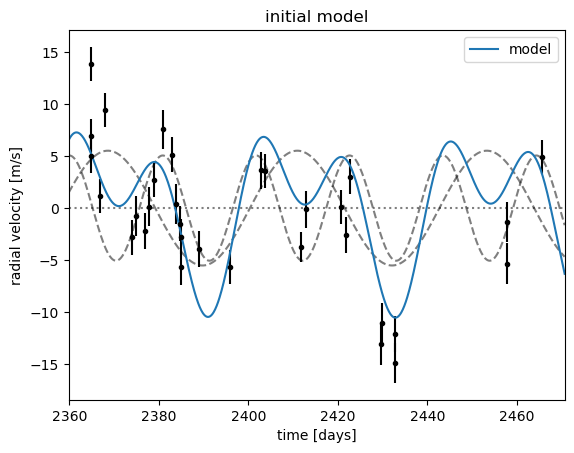

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In [9]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[trend])
    map_soln = pmx.optimize(start=map_soln, vars=[t0, trend, logK, logP, logs])
    map_soln = pmx.optimize(start=map_soln, vars=[ecs])
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -68.03907701822234 -> -57.4213493739168
optimizing logp for variables: [logs, logP, logK, trend, t0]


message: Optimization terminated successfully.
logp: -57.4213493739168 -> -51.81968815504228
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -51.81968815504228 -> -50.93559539327122
optimizing logp for variables: [trend, logs, ecs, logK, logP, t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -50.93559539327122 -> -50.765648030597134


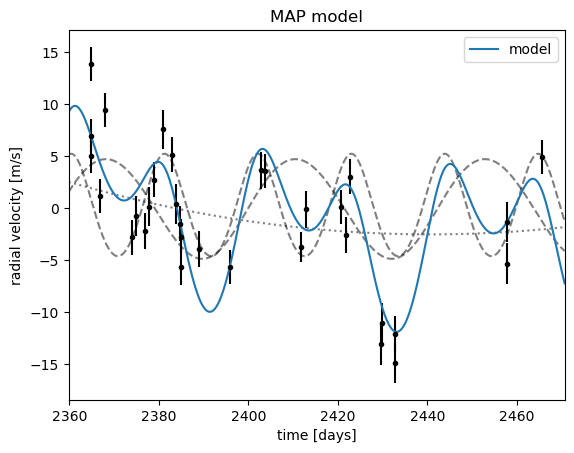

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

In [11]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=1000,
        draws=1000,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [trend, logs, ecs, logK, logP, t0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [12]:
import arviz as az

az.summary(
    trace, var_names=["trend", "logs", "omega", "ecc", "t0", "logK", "P"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trend[0],0.001,0.001,-0.001,0.002,0.000,0.000,1653.0,1630.0,1.0
trend[1],-0.041,0.025,-0.085,0.012,0.001,0.000,2227.0,1056.0,1.0
trend[2],-1.852,0.785,-3.326,-0.362,0.018,0.013,1859.0,1551.0,1.0
logs,1.124,0.208,0.749,1.533,0.006,0.005,1060.0,1276.0,1.0
omega[0],0.004,1.230,-1.924,3.046,0.028,0.022,1994.0,1416.0,1.0
omega[1],-0.269,1.977,-3.085,2.882,0.049,0.035,1518.0,1824.0,1.0
ecc[0],0.087,0.092,0.000,0.283,0.004,0.003,737.0,932.0,1.0
ecc[1],0.049,0.056,0.000,0.114,0.003,0.002,844.0,531.0,1.0
t0[0],2072.795,0.001,2072.793,2072.796,0.000,0.000,2566.0,1640.0,1.0
t0[1],2082.625,0.000,2082.624,2082.626,0.000,0.000,1925.0,1338.0,1.0


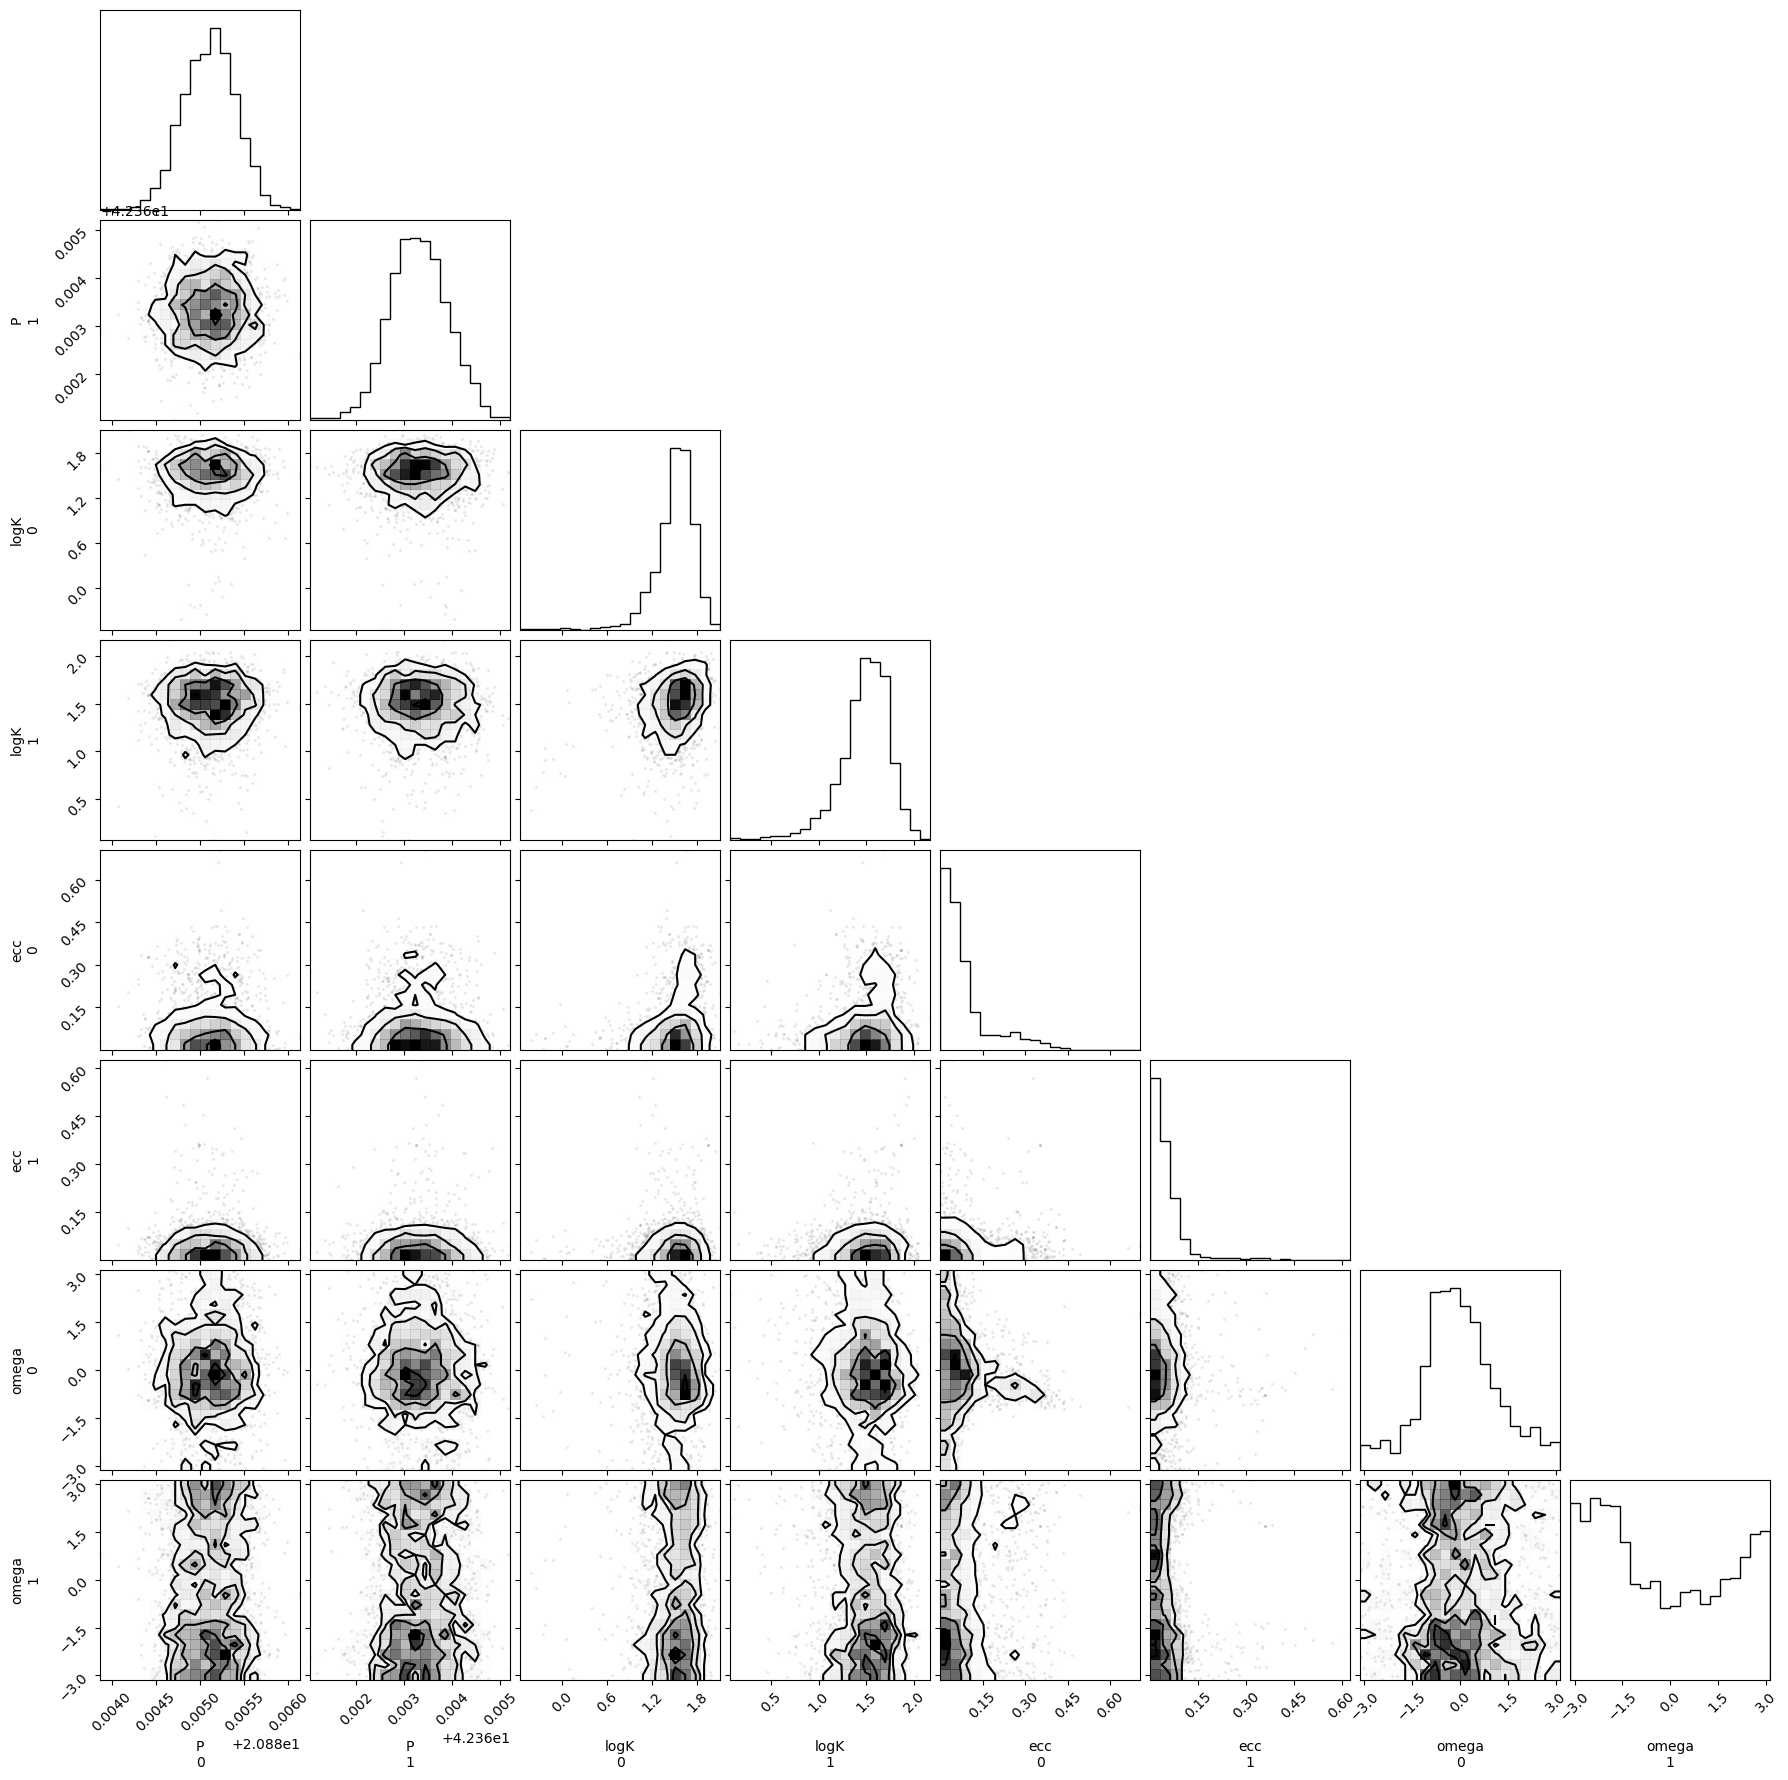

In [13]:
import corner

with model:
    _ = corner.corner(trace, var_names=["P", "logK", "ecc", "omega"])

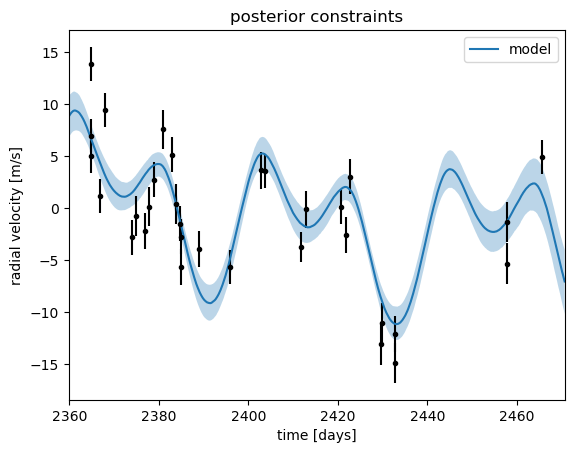

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("posterior constraints")

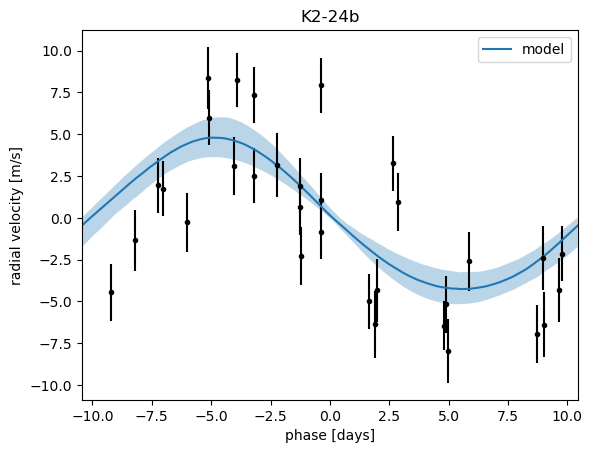

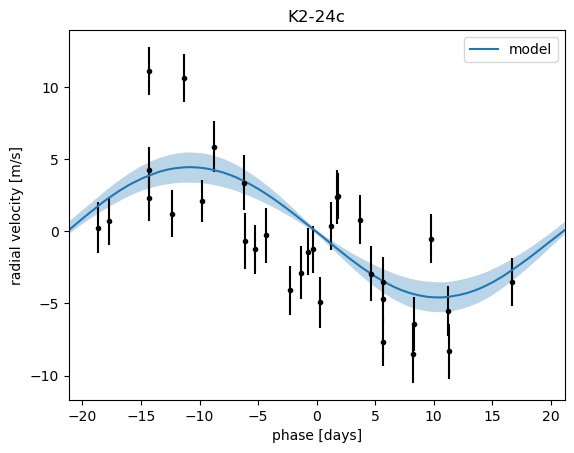

In [15]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace.posterior["P"].values[:, :, n])
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(
        trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
    )
    other += np.median(trace.posterior["bkg"].values, axis=(0, 1))

    # Plot the folded data
    x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")

    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    inds = np.argsort(t_fold)
    pred = np.percentile(
        trace.posterior["vrad_pred"].values[:, :, inds, n],
        [16, 50, 84],
        axis=(0, 1),
    )
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(
        t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3
    )
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter))